
# Module 2: CUDA

---
## Introduction
In this assignment, we will get more experience writing programs that utilize our CUDA-enabled GPU. Additionally, we'll perform a small case study that looks at the resulting performance of GPUs vs. CPUs for certain types of programs.

Before moving on, please watch lecture videos Parts 1 - 3 to complete this section. 

This assignment will cover:

* Calls to the kernel
* Vector Addition
* Matrix Addition
---
## Materials
* Lecture Videos
    * [Part 1](https://drive.google.com/file/d/1q4Hi9dKXhtOD0rDh3VvzoUn2OhqHXGJ-/view)
    * [Part 2](https://drive.google.com/file/d/14F1MAbD69esFYLT2dIYDniVKex9ol4U7/view?usp=sharing)
    * [Part 3](https://drive.google.com/file/d/1N8Ps0L7tL1B2sJx9XMHuw9H_CQMdCxLX/view?usp=sharing)
    * Optional material: [Part 4](https://drive.google.com/file/d/1vqdP4SEswH5gVIZ2J2Qo8rhRN04gCEx8/view?usp=sharing)
* [Slides](https://docs.google.com/presentation/d/1SsCLm-Z3ZxQJ9F3DFjk0OKpBNGyDcVNThvxqIELRmic/edit?usp=sharing)
---
## Assignment
There are three parts to this assignment:

* Part 0: CUDA in Colab
* Part 1: Kernel Calls
* Part 2: Vector Addition
* Part 3: Matrix Addition
---
## Module Learning Objectives
* Introduce making calls to the kernel
* Cover `cudaMalloc` and `cudaMemcpy` operations
* Recognize similarities between vector addition and matrix addition
* Understand memory arguments
* Use nvprof to see how much time is spent in the kernel
* Use the time `UNIX` utility
* Introduction to threads, blocks, and resulting performance gain
* Understand the different ways we can get a thread's index
* Writing a grid-stride loop vs. monolithic kernels
* Understand row-major order (memory layout)
* Make a graph to visualize performance
* Write C code and its CUDA equivalent


## Part 0: CUDA in Colab

### Specifying runtime configuration

Similar to how we wrote our C programs in the previous module, we need to do something similar when writing our CUDA programs as well. Instead of `%%writefile my_program.c`, we now use the NVIDIA CUDA compiler, `nvcc`. 

* **But before we do that, we need to change our Runtime Type--we now want to use a GPU! From the menu, select `Runtime` > `Change runtime type` > `GPU`. Leave the checkbox un-selected--that way, the output of each of your cells is preserved.**

* **Only change the runtime to GPU once you are ready to run your programs. If you leave a notebook open for too long, you might lose conenctivity to your runtime environment.**

`nvcc` should be installed on Colab by default. You can run the cell below to see the specific version:

### Configuring our environment

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


We also need to install a plugin to let us write CUDA programs in our cells. Do a `pip install`, and then load the plugin into Colab.

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-00_sjq87
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-00_sjq87
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4305 sha256=35eea9634fb691a866c61f6d42131111e5a7eefbc036b2011429476edd81c44f
  Stored in directory: /tmp/pip-ephem-wheel-cache-09i17rjn/wheels/c5/2b/c0/87008e795a14bbcdfc7c846a00d06981916331eb980b6c8bdf
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


**If the notebook becomes inactive for a long period of time, you may need to re-run the above two cells to re-install the `nvcc` plugin.**

Google has a few different types of GPUs that it can give you--depending on the one you receive, you need to compile your programs with the appropriate architecture (this is known as the compute capability). 

`!nvidia-smi` gives us information on the card that we were assigned:

In [ ]:
!nvidia-smi

Mon Dec  6 23:18:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Here I was given a `Tesla K80`. The associated compute capability with this card is `3.7`, and we'll need to keep track of this when compiling our programs. 

[Here's](https://developer.nvidia.com/cuda-gpus#compute) a reference of some of the other possible graphics cards Google might give you (along with their associated compute capabilities):  


| GPU      | Compute Capability | `-arch flag` |
| :-----------: | :-----------: | :-----------: |
| Tesla K80 | 3.7 | `-arch=sm_37` |
| NVIDIA T4 | 7.5 | `-arch=sm_75`   |
| NVIDIA P4 | 6.1 | `-arch=sm_61` |
| NVIDIA P100 | 6.0 | `-arch=sm_60`|

### Writing and compiling our first program

Now, when writing CUDA programs, we place `%%cu` at the top of each cell. We specify a name for our program using `--name`, and once we run the cell our source code for our CUDA program will be saved under `./src`. **The source code for your CUDA programs will be stored under `./src`. Other programs that you write, such as your C programs, will be in the current directory.**

In [ ]:
%%cuda --name hello-world.cu

#include <stdio.h>

__global__ void hello()
{
    printf("Hello from CUDA!\n");
}


int main()
{
    hello<<<1,1>>>();

    cudaDeviceSynchronize();

    return 0;
}



'File written in /content/src/hello-world.cu'

When compiling our programs, we pass in the location of our source code (`./src/hello_world.cu`) and the `-arch` flag (stands for architecture). The compute capability for our GPU is `-arch=sm_37`.

In [ ]:
!nvcc ./src/hello-world.cu -o hello-world -arch=sm_37

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [ ]:
!./hello-world

Hello from CUDA!


## Part 1: Kernel Calls

### Introduction


As shown in lecture, kernel code lets our compiler know that certain code should be run on the device (our GPU) instead of our host macine. We use `<<<NUM_BLOCKS, NUM_THREADS>>>` to specify our memory arguments, and to tell CUDA how many threads and blocks we would like to launch. Threads are grouped into blocks called "thread blocks," and multiple thread blocks make up a "grid." Each thread and block maps to specific type of processor on the GPU.

### Division: A quick example

Let's say we wanted to create a kernel call to divide two numbers. Remember that from lecture (and the slides) that we need to use `cudaMalloc` to allocate space on the GPU for our variables and `cudaMemcpy` to copy our values over. 

* Our kernel is pretty straightforward. We take in two numbers, `a` and `b`, and store the result in `c`. 
* We then allocate space on the GPU for our result. Since we are passing in `a` and `b` through kernel arguments, they are automatically copied over to the GPU, so there's no need for a `cudaMemcpyHostToDevice` here.
* Once the result is computed and on the GPU, we need to get it back! We do `cudaMemcpy`, this time from the device (our GPU) back to the host (our CPU).

A common occurrence in most CUDA programs is setting up our `host` and `device` pointers. Let's look at an example.

In [ ]:
%%cuda --name divide.cu

#include <stdio.h>

/*
 * divide.cu
 * 
 * Divides two numbers using the GPU.
 *
 * Compile with: !nvcc ./src/add.cu -o divide-cuda
 * Run with: !./divide-cuda
 */

__global__ void divide(int a, int b, int* c)
{
    *c = a / b;
}

int main()
{
    int size = sizeof(int);

    /* 
     * Set up our host and device pointers. 
     * Eventually, our answer will be stored
     * in dev_c 
     */ 
    int host_c;
    int* dev_c;
 
    /* 
     * Allocate space for our result on the GPU. 
     * Remember that cudaMalloc needs a _POINTER_!
     */
    cudaMalloc(&dev_c, size);
 
    /* Call our kernel, passing in our arguments */
    divide<<<1,1>>>(42, 7, dev_c);
 
    /*
     * Answer now stored in dev_c, copy it back to the host.
     * Remember that cudaMemcpy needs a _POINTER_ to the 
     * device and host from where you are performing the copy.
     */
    cudaMemcpy(&host_c, dev_c, size, cudaMemcpyDeviceToHost);
 
    printf("42 / 7 = %d", host_c);
 
    /* Free our device memory */
    cudaFree(dev_c);
}

'File written in /content/src/divide.cu'

In [ ]:
!nvcc ./src/divide.cu -o divide-cuda -arch=sm_37
!./divide-cuda

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
42 / 7 = 6

### Addition

Given below is a CPU implementation for a function add that adds two numbers. Your task is to create a CUDA program (`add.cu`) that performs the same operation, except this time makes a kernel call. You need to ensure that you allocate memory on the device, transfer your data over, and free the used memory once you are done. Use 1 block and 1 thread when performing this operation.

In [ ]:
%%writefile add.c

#include <stdio.h>

/*
 * add.c
 * 
 * Adds two numbers using the CPU.
 *
 * Compile with: !gcc add.c -o add
 * Run with: !./add
 */

int add(int a, int b, int* c)
{
    *c = a + b;
}

int main()
{
    int c;
    
    add(3, 9, &c);
    printf("CPU says: 3 + 9 = %d", c);
}

Overwriting add.c


In [ ]:
!gcc add.c -o add
!./add

CPU says: 3 + 9 = 12

### Multiplication

This time we are given the following CPU implementation for a function that multiplies two numbers. It's similar to what we had above, except this time, the function signature is a bit different: `a`, `b`, and `c` are all pointers! 
```c
int multiply(int* a, int* b, int* c)
{
    *c = *a * *b;
}
```

This means that you'll have to copy over **all three** variables to the GPU--you need to allocate enough space for `a`, `b`, and `c`, copy over the values for `a` and `b`, and then copy the result back to the host. Now, we pass the location of `a`, `b`, and `c` on the GPU to our kernel arguments (or our `dev_x` variables).

Write a CUDA program (`multiply.cu`) that performs this operation. Use 1 block and 1 thread when crafting your call to the kernel.

In [ ]:
%%writefile multiply.c

#include <stdio.h>

/*
 * multiply.c
 * 
 * Multiplies two numbers using the CPU.
 *
 * Compile with: !gcc multiply.c -o multiply
 * Run with: !./multiply
 */

int multiply(int* a, int* b, int* c)
{
    *c = *a * *b;
}

int main()
{
    int c;
 
    int num1 = 3;
    int num2 = 9;
    
    multiply(&num1, &num2, &c);
    printf("CPU says: 3 * 9 = %d", c);
}

Overwriting multiply.c


In [ ]:
!gcc multiply.c -o multiply
!./multiply

CPU says: 3 * 9 = 27

### Tasks

* Implement `add.cu` and `multiply.cu`

### `add.cu`

In [ ]:
%%cuda --name add.cu

/* TODO */

int main
{
    return 0;
}

### `multiply.cu`

In [ ]:
%%cuda --name multiply.cu

/* TODO */

int main()
{
    return 0;
}

## Part 2: Vector Addition

### Introduction

Vectors have an important role in the world of physics and computer graphics. In this section (and later on when we deal with matrices), we'll take a deeper look at the memory arguments of a kernel call and observe the affect varying the number of blocks and threads has on the runtime of our programs.

### C implementation (`vector_add.c`) and a quick refresher


Before you start implementing `vector_add.c`, briefly recall the thought process behind vector addition for vectors of an arbitrary length `N`. For now, we represent each vector as an integer array.

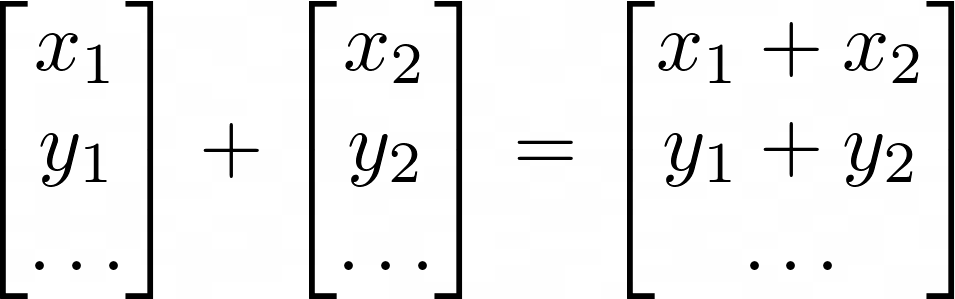

Provided is some starter code for the C implementation of vector addition (`vector_add.c`). You can print out vector `c` to make sure your implementation is working, but comment those lines out before you move on. Instead of allocating memory on the stack, we are using `malloc` here due to the extremely large size of `N`.

In [ ]:
%%writefile vector_add.c

#include <stdio.h>
#include <stdlib.h>

/*
 * vector_add.c 
 * 
 * Adds two vectors and displays the result.
 */

/* Number of elements in each vector */
 #define N 1000000

void vector_add(int* a, int* b, int* c)
{ 
    /* TODO */
     ...
}

int main() 
{
    /* Allocate space for vectors a, b, and c */
    int* a = (int*)malloc(sizeof(int) * N);
    int* b = (int*)malloc(sizeof(int) * N);
    int* c = (int*)malloc(sizeof(int) * N);

    /* Populate vectors a and b with values */
     ...
    /* Perform the addition */
     ...
    /* Free memory when done */
    free(...);
    free(...);
    free(...);
 }


### CUDA implementation

Create the corresonding CUDA implementation, but leave your memory arguments `<<<NUM_BLOCKS,NUM_THREADS>>>(dev_a, dev_b, dev_c)` when making the `vector_add` kernel call empty. We will vary the number of blocks and threads and gather some performance data using `nvprof` in the sections below.

To establish a "baseline" to judge our performance, spawn 1 block with 1 thread when making your call to the kernel. **You shouldn't have to change the implementation of your `vector_add` function when implementing this first kernel.** Set `N` = `1000000`.

In [ ]:
%%cuda --name vector_add.cu

#include <stdio.h>
#include <stdlib.h>

/* Number of elements in each vector */
 #define N 1000000

__global__ void vector_add(...)
{
    /* TODO */
}

int main()
{
    /* Allocate space for vectors a, b, and c */
    int* a = (int*)malloc(sizeof(int) * N);
    int* b = (int*)malloc(sizeof(int) * N);
    int* c = (int*)malloc(sizeof(int) * N);

    /* Populate vectors a and b with values */
     ...
 
    /* TODO *

    /* Perform the addition */
     ...
    /* Free memory when done (both host and device) */
    free(...);
    free(...);
    free(...);

    return 0;
}

'File written in /content/src/vector_add.cu'

### Scenario 1: Establishing a baseline (`vector_add_baseline.cu`)


Using the UNIX command `time`, measure the `real` time it takes for `vector_add.c` to run. Here's an example using `divide.cu` and the corresponding executable: 

In [ ]:
!time ./divide-cuda

42 / 7 = 6
real	0m0.154s
user	0m0.011s
sys	0m0.132s


Repeat this process once more, but this time give your CUDA exectuable.

After obtaining both of these values, put them in the table below:

| Implementation | Time (seconds) | 
| :--- | :--- |
|`C` (`vector_add.c`) | **TODO: Your answer here** |
|`CUDA` (`vector_add_baseline.cu`) | **TODO: Your answer here** |

> What do the times look like for each program? Is one implementation slower than the other? If so, explain the reason for the resulting discrepancy.\
**TODO: Your answer here**

> Using [`nvprof`](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview) (a tool that lets you look at the metrics for CUDA kernels), find the `Avg` amount of time spent within the kernel. What CUDA `API` call was called the most?\
**TODO: Your answer here**

`nvprof`, the NVIDIA profiler, can help us to gain more insight into our CUDA programs:

In [ ]:
!nvprof ./divide-cuda

==2975== NVPROF is profiling process 2975, command: ./divide-cuda
==2975== Warning: Auto boost enabled on device 0. Profiling results may be inconsistent.
42 / 7 = 6==2975== Profiling application: ./divide-cuda
==2975== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   52.63%  3.5200us         1  3.5200us  3.5200us  3.5200us  divide(int, int, int*)
                   47.37%  3.1680us         1  3.1680us  3.1680us  3.1680us  [CUDA memcpy DtoH]
      API calls:   99.66%  268.36ms         1  268.36ms  268.36ms  268.36ms  cudaMalloc
                    0.18%  471.37us         1  471.37us  471.37us  471.37us  cuDeviceTotalMem
                    0.07%  185.62us       101  1.8370us     147ns  77.449us  cuDeviceGetAttribute
                    0.05%  121.25us         1  121.25us  121.25us  121.25us  cudaFree
                    0.02%  42.165us         1  42.165us  42.165us  42.165us  cuDeviceGetName
                    0.01%

### Scenario 2: Single Block, Many Threads (`vector_add_threads.cu`)

Now that we have established our baseline measurement with `N` = `1000000` elements, let's see how we can speed things up. We'll make use of SIMT (Single Instruction, Multiple Threads) to achieve high parallel performance for our vector computation. This time, create `vector_add_threads.cu` where you spawn `1` block with `256` threads. Define a constant `T` to represent the number of threads. The idea here is that in parallel, each thread will be responsible for performing a step of the vector addition.

Note that you will now have to make some changes to your `vector_add` kernel. If we only changed the number of threads in our memory arguments, we would be repeating the same computation once per thread instead of spreading it across multiple, parallel threads.

For example, we want Thread ID `0` to be responsible for adding the first element of both vectors. Once it has done its job, it should start solving a new portion of the problem--ideally, the 256th element of both vectors. 

Modify your existing kernel's loop to account for this behavior (ideally, spawning a new thread every iteration that solves a different portion of the problem). `blockIdx.x` and `threadIdx.x` might be helpful here.

Refer to the pseudocode below:
```c
__global__ void vector_add(int* a, int* b, int* c) {
    /* Find the unqiue ThreadID of each thread that we spawn */
    ...
    /* Find the value we need to increment by to work on a new
       portion of the problem each time */
    ...
    /* Logic to add vectors together */
    ...
}
```

In [ ]:
%%cuda --name vector_add_threads.cu

#include <stdio.h>
#include <stdlib.h>

/* Number of elements in each vector */
 #define N 1000000

__global__ void vector_add(...)
{
    /* TODO */
}

int main()
{
    /* Allocate space for vectors a, b, and c */
    int* a = (int*)malloc(sizeof(int) * N);
    int* b = (int*)malloc(sizeof(int) * N);
    int* c = (int*)malloc(sizeof(int) * N);

    /* Populate vectors a and b with values */
     ...
 
    /* TODO */

    /* Perform the addition */
     ...
    /* Free memory when done (both host and device) */
    free(...);
    free(...);
    free(...);

    return 0;
}

Use `nvprof` to run your implementation on a vector with `N` = `1000000` elements. Note down the time spent in the kernel.

### Scenario 3: Introducing Blocks (`vector_add_blocks.cu`)


Finally, we are going to see the impact on performance when adding multiple blocks and threads. The idea is to split up the work of addition between different blocks, each with `N` threads. Each thread will process a single row operation for the vector addition. Once again, launch `256` threads. Define a constant `T` to represent the number of threads.

When determining the number of blocks you need, note that each block is reserved completely. Functions like `ceil` and `(int)` type-casting might be helpful here.

> Write the memory arguments that you would pass in to your kernel call. Your answer should be in terms of `N` (number of elements in your vector) and `T` (number of threads we are spawning).\
**TODO: Your answer here**

In addition to changing your memory arguments, you will need to re-calculate the Thread ID within your kernel call (`vector_add`). You now need to compute the **Global** Thread ID with respect to the block you are in as well.

> Write the snippet for calculating the Global Thread ID. Feel free to make use of CUDA's built-in variables, such as `threadIdx.x`, etc.\
**TODO: Your answer here**


Finally, modify the kernel by adding a bounds check so writes beyond the bounds of allocated memory are not allowed. Ensure that threads with a given Thread ID do not exceed `N`.

Use `nvprof` to run your implementation on a vector with `N` = `1000000` elements. Note down the time spent in the kernel.

In [ ]:
%%cuda --name vector_add_blocks.cuda

#include <stdio.h>
#include <stdlib.h>

/* Number of elements in each vector */
 #define N 1000000

__global__ void vector_add(...)
{
    /* TODO */
}

int main()
{
    /* Allocate space for vectors a, b, and c */
    int* a = (int*)malloc(sizeof(int) * N);
    int* b = (int*)malloc(sizeof(int) * N);
    int* c = (int*)malloc(sizeof(int) * N);

    /* Populate vectors a and b with values */
     ...
 
    /* TODO */

    /* Perform the addition */
     ...
    /* Free memory when done (both host and device) */
    free(...);
    free(...);
    free(...);

    return 0;
}

### Analysis

Fill in the table with your results from Scenarios 1-3:

| Scenario | Time (ms) | Speedup |
| :--- | :--- | :--- |
|1: Baseline | **TODO** | 1.00x|
|2: Threads | **TODO** | **TODO** |
|3: Blocks and Threads | **TODO** | **TODO**|

> What do your observations show? What effect do threads and blocks have on the performance of vector addition?\
**TODO: Your answer here**

### Tasks

* Implement `vector_add.c`
* Complete the **short answer questions** and **tables** in Scenarios 1-3, and implement the following files:
    * `vector_add_baseline.cu`
    * `vector_add_threads.cu`
    * `vector_add_blocks.cu` 

## Part 3: Matrix Addition

### Introduction

In this module, we will continue to explore GPU performance when it comes to matrix operations. Specifically, we will focus on matrix addition.



### C implementation (matrix_add.c) and a quick refresher


Before you start implementing `matrix_add.c`, briefly recall the thought process behind matrix addition for two `N` X `N` matrices (building off of our previous implementation of vector addition).

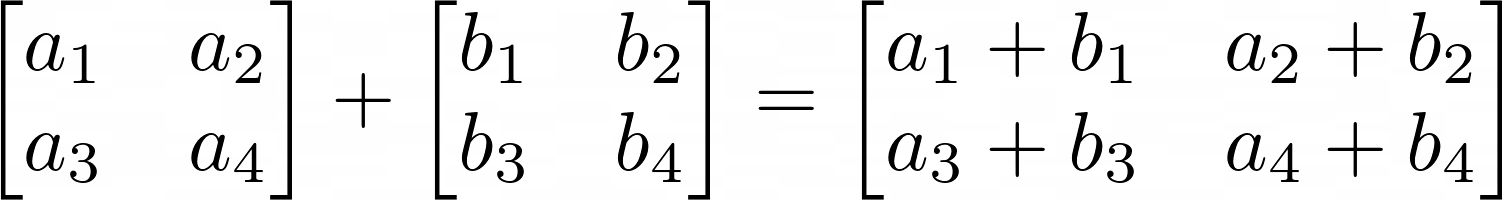

### Matrix representation

In general, dynamically allocated memory on the device (our GPU) doesn't allow for two-dimension row-column indexing (`my_matrix[row][col]`) to access 2-D arrays. C uses [**row-major**](https://en.wikipedia.org/wiki/Row-_and_column-major_order) order when storing our matrices--each row ends up being stored one after the other:

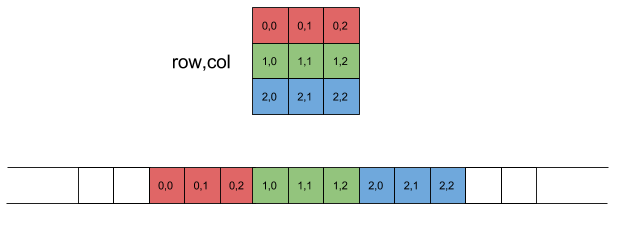

> Write an expression that gets you the element`(row,col)` in an `N` x `N` matrix `M`. Your answer should be in terms of `row`, `col`, and `N`.\
**TODO: Your answer here**


Provided is some starter code for the **C** implementation of matrix addition (`matrix_add.c`).

In [ ]:
%%writefile matrix_add.c

#include <stdio.h>
#include <stdlib.h>

/*
 * matrix_add.c
 * 
 * Adds two matrices and displays the result. 
 */

/* Dimensions of square matrix N */
#define N 5

void matrixAdd(int* a, int* b, int* c) {
    /*...TODO...*/
    ...
}

int main() {
    /* Allocate space for matrices a, b, and c */ 
    int* a = malloc(N * N * sizeof(int));
    int* b = malloc(N * N * sizeof(int));
    int* c = malloc(N * N * sizeof(int));
    
    /* Populate each matrix with values */
    ...

    /* Perform addition */
    ...

    /* Free memory when done */
    ...
}


### Hints

**A Note on Dimensions**

In comparison to `vector_add.cu`, note that we are now dealing with 2 dimensions. Recall from lecture that CUDA has built-in variables and structures to represent the current block and thread in each dimension. Just like before, you should only need a certain number of blocks to cover your problem space--using `ceil` and `(int)` will be helpful here when finding your `dim3 grid`.

### CUDA Implementation 


Create the corresponding CUDA implementation (`matrix_add.cu`). When making your call to the kernel, add a bounds check to make sure you are never accessing elements that are outside of the bounds of `N`. Use the provided `BLOCK_DIM` of 32.

> You should have a variable of `dim3` which represents the number of threads within each block. What is the maximum value for this variable? Why is this the case?\
**TODO: Your answer here**

You might find a tool like [`cuda-memcheck`](https://docs.nvidia.com/cuda/cuda-memcheck/index.html) to be helpful here.

In [ ]:
%%cuda --name matrix_add.cu

#define N 5
#define BLOCK_DIM 32

__global__ void matrixAdd(...)
{
    int row = ...
    int col = ...
 
    int index = ...
 
    if (row < N && col < N)
    {
        /* TODO */
    }
 
}

int main()
{ 
    /* Allocate space for matrices a, b, and c */
    int* a = malloc(N * N * sizeof(int));
    int* b = malloc(N * N * sizeof(int));
    int* c = malloc(N * N * sizeof(int));
 
    /* Populate elements */
    ...
 
    dim3 dimBlock = ( /* TODO */ );
    dim3 dimGrid = ( /* TODO */ );
 
    /* Perform addition */
    ...
 
    /* Free memory when done (host and device) */
    ...
}

### Performance Case Study

We'll now perform a small case study on performance using the two implementations you just created: `matrix_add.c` and `matrix_add.cu`. When gathering your data, **don't** print the result of your calculated matrix--this will cause the runtime to be quite slow.

> **TODO**: Use the UNIX [`time`](https://man7.org/linux/man-pages/man1/time.1.html) utility to fill in as many values as you can for N below:

| N (# of elements)| `matrix_add.c` (sec) | `matrix_add.cu` (sec) |
| :--- | :--- | :--- |
| 5 | -- | -- |
| 50 | -- | -- |
| 500 | -- | -- |
| 5000 | -- | -- |
| 10000 | -- | -- |
| 15000 | -- | -- |
| 20000 | -- | -- |
| 25000 | -- | -- |
| 30000 | -- | -- |
| 32000 | -- | -- |

Once you have filled in the above values, make a graph to better visualize your findings. Use [Google Colab](https://colab.research.google.com/) to make a quick visualization, following the template for a similar graph below:

```python
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

N = [...#TODO...]
matrix_add_perf_C = [...#TODO...]
matrix_add_perf_CUDA = [...#TODO...]

plt.plot(N, ...#TODO..., label='...#TODO...')
plt.plot(N, ...#TODO..., label='...#TODO...')
plt.xlabel(...#TODO...)
plt.ylabel(...#TODO...)
plt.title('Matrix Addition')
plt.legend()
plt.savefig('matrix_add_perf.png')
files.download('matrix_add_perf.png')
```

> **TODO: Paste your version of `matrix_add_perf.png` below:**

**...**

> What conclusions can you draw from your graph? What happens to the performance of both implementations as the size of `N` gets larger?\
**TODO: Your answer here**

Here is a sample graph for your reference:

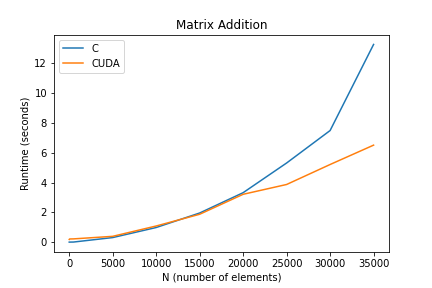

### Tasks

* Implement `matrix_add.c` and `matrix_add.cu`
* Complete the **short answer questions** and populate the **table** with the data you collected
* Attach a picture of your performance graph (`matrix_add_perf.png`)

## All Done?
Navigate to `File` > `Download` > `Download .ipynb`. You can later submit this `.ipynb` file as an attachment after running each of your cells in the [Course Feedback survey](https://docs.google.com/forms/d/e/1FAIpQLSfAYjrJ04aurqE96z-OdUVWsLwdlq14oPKBUJRkShzfZtn6Gg/viewform).